Arindita Prihastama | 1494037162100-370 | arinditap@gmail.com

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"galaxydnjv","key":"d118279921159142dae11e31eb72abb1"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d muratkokludataset/rice-image-dataset

 99% 218M/219M [00:12<00:00, 23.2MB/s]
100% 219M/219M [00:12<00:00, 18.7MB/s]


In [5]:
import os, zipfile

In [12]:
dir = '../content/rice-image-dataset.zip'
zipFile = zipfile.ZipFile(dir, 'r')
zipFile.extractall('../content/RiceDataset')
zipFile.close()

In [13]:
file_dir = '../content/RiceDataset/Rice_Image_Dataset/'

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split = 0.2
)

In [16]:
train_generator = train_datagen.flow_from_directory(
    file_dir,
    target_size = (150, 150),
    batch_size = 64,
    class_mode = 'categorical',
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    file_dir,
    target_size = (150, 150),
    batch_size = 64,
    class_mode = 'categorical',
    subset = 'validation'
)



Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [23]:
import tensorflow as tf

In [24]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (5,5), padding = 'Same', activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding = 'Same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

In [26]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [28]:
from keras.callbacks import Callback, EarlyStopping

In [29]:
class TargetCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
      print("\n Accuracy and Validtion Accuracy has reached 95%! Training Stopped")
      self.model.stop_training = True
Target = TargetCallback()

EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.0001,
    patience = 5,
    verbose = 1,
    mode = 'auto'
)

In [30]:
History = model.fit(
    train_generator,
    epochs = 100,
    validation_data = val_generator,
    callbacks = [Target, EarlyStop],
    verbose = 1
)

Epoch 1/100
938/938 [==============================] - 366s 382ms/step - loss: 0.2500 - accuracy: 0.9156 - val_loss: 0.0844 - val_accuracy: 0.9689
Epoch 2/100
938/938 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9565
 Accuracy and Validtion Accuracy has reached 95%! Training Stopped
938/938 [==============================] - 355s 379ms/step - loss: 0.1289 - accuracy: 0.9565 - val_loss: 0.0858 - val_accuracy: 0.9708


In [31]:
import matplotlib.pyplot as plt

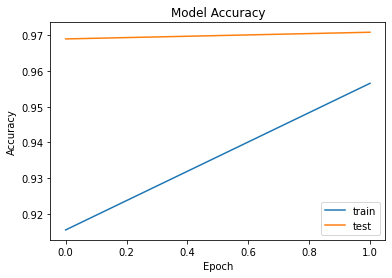

In [33]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')

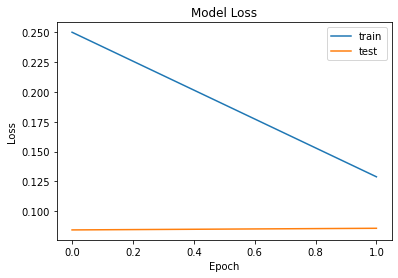

In [34]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')

In [35]:
import pathlib

In [37]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('RiceClassification.tflite')
tflite_model_file.write_bytes(tflite_model)

5412076